In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('nature')

## RMSD of MMP2 only

In [2]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('mmp2_only_sim/sys_prod/prod_mmp2_only.gro', 'mmp2_only_sim/sys_prod/prod_mmp2_only_compact_compact.xtc')

In [3]:
R = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

  0%|          | 0/30001 [00:00<?, ?it/s]

## Radius of Gyration: MMP2 only

In [4]:
from tqdm import tqdm
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(protein_prod.trajectory):
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 30001/30001 [05:34<00:00, 89.57it/s] 


## RMSD of MMP2 and TDL Complex

In [5]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex.gro', 'mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex_compact_compact.xtc')

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [6]:
R = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]

  0%|          | 0/30001 [00:00<?, ?it/s]

## Radius of Gyration: MMP2 and TDL Complex

In [7]:
from tqdm import tqdm
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(complex_prod.trajectory):
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 30001/30001 [05:55<00:00, 84.50it/s]


## RMSF: Protein backbone and Carbon alpha

In [21]:
c_alphas_p = protein_prod.select_atoms('backbone and name CA')
R_p = rms.RMSF(c_alphas_p).run(verbose=True)

c_alphas_c = complex_prod.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)

  0%|          | 0/30001 [00:00<?, ?it/s]

  0%|          | 0/30001 [00:00<?, ?it/s]

In [22]:
mda.__version__

'2.8.0-dev0'

## H-bond analysis:

Note: as of today (20240929), the latest stable version of `mdanalysis-2.7.0` cannot import `GROMACS` tpr files from `gromacs-2024.2`, yielding this exception

```python
ValueError: Failed to construct topology from file zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.tpr with parser <class 'MDAnalysis.topology.TPRParser.TPRParser'>.
Error: Your tpx version is 133, which this parser does not support, yet
```

So we have to install the development version from GitHub. 

### Instructions:

```bash
$ conda create -n mdanalysis-develop numpy cython ipykernel ipywidgets
$ conda activate mdanalysis-develop
$ git clone --depth=50 https://github.com/MDAnalysis/mdanalysis.git
$ cd mdanalysis
$ git branch

* develop

$ pip install package/
$ pip install testsuite/ #Optional
$ python -c 'import MDAnalysis as mda; print(mda.__version__)'
2.8.0-dev0
```
Then, reload jupyter kernel in this new environment.

Background: [MDAnalysis example: Hydrogen Bonds](https://userguide.mdanalysis.org/stable/examples/analysis/hydrogen_bonds/hbonds.html)

In [24]:
#Giving full tpr file to include bonding info
u = mda.Universe("mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex.tpr",\
            "mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex_compact_compact.xtc")
tdl = u.select_atoms('resname TDL')
protein = u.select_atoms('protein')
num_residues = len(protein.residues)

Note that we're selecting TDL and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

**Note** The selections need to be super precise and atom specific, otherwise there will be many false positives during the hydrogen bond detection, as it will try to 'detect' hydrogen bonds for every atom in the selection, even ones that aren't electronegative enough to be donors and/or acceptors. So selections for donors and acceptors should be obtained with the `guess_` methods.

In [43]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_prot_tdl = HBA(universe=u,
        d_h_cutoff=1.2,
        d_a_cutoff=3.35,
        d_h_a_angle_cutoff=150.0,
        update_selections=False
        )

hbonds_prot_tdl.donors_sel = hbonds_prot_tdl.guess_donors("protein")
hbonds_prot_tdl.hydrogens_sel = hbonds_prot_tdl.guess_hydrogens("protein")
hbonds_prot_tdl.acceptors_sel = hbonds_prot_tdl.guess_acceptors("resname TDL")

hbonds_prot_tdl.run(verbose=True)

  0%|          | 0/30001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.35 between Donor, (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ASH and name OD2) or (resname ASN and name ND2) or (resname GLH and name OE2) or (resname GLN and name NE2) or (resname SER and name OG) or (resname THR and name OG1) or (resname TYR and name OH), and Acceptor, (resname TDL and name O1) or (resname TDL and name O2).
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150.0 between Donor, (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ASH and name OD2) or (resname ASN and name ND2) or (resname GLH and name OE2) or (resname GLN an

The average number of each type of hydrogen bond formed at each frame is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [44]:
sorted_output = sorted(hbonds_prot_tdl.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_prot_tdl.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

THR:OH to TDL:o: 0.035


In [45]:
sorted_output

[array(['THR:OH', 'TDL:o', '20128'], dtype='<U21')]

Just one Hbond between MMP2 residues as donors and TDL as acceptor. So we'll have to switch the roles. Now running with TDL as donor and MMP2 residues as acceptor.

In [46]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_tdl_prot = HBA(universe=u,
        d_h_cutoff=1.2,
        d_a_cutoff=3.35,
        d_h_a_angle_cutoff=150.0,
        update_selections=False
        )

hbonds_tdl_prot.donors_sel = hbonds_tdl_prot.guess_donors("resname TDL")
hbonds_tdl_prot.hydrogens_sel = hbonds_tdl_prot.guess_hydrogens("resname TDL")
hbonds_tdl_prot.acceptors_sel = hbonds_tdl_prot.guess_acceptors("protein")

hbonds_tdl_prot.run(verbose=True)

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/core/groups.py:3386: UserWarning: Empty string to select atoms, empty group returned.
  warnings.warn("Empty string to select atoms, empty group returned.",


  0%|          | 0/30001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.35 between Donor, , and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASH and name O) or (resname ASH and name OD1) or (resname ASH and name OD2) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYM and name O) or (resname CYM and name SG) or (resname CYS and name O) or (resname CYS and name OC1) or (resname CYS and name OC2) or (resname CYX and name O) or (resname GLH and name O) or (resname GLH and name OE1) or (resname GLH and name OE2) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN a

In [47]:
sorted_output = sorted(hbonds_tdl_prot.count_by_type(), key=lambda x: float(x[2]), reverse=True)
for donor, acceptor, count in sorted_output:
    donor_resname, donor_type = donor.split(":")
    n_donors = u.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms
    mean_count = 2 * int(count) / (hbonds_tdl_prot.n_frames * n_donors)
    print(f"{donor} to {acceptor}: {mean_count:.3f}")

Bupkiss! No hbonds detected between TDL as donor and protein as acceptor.

In [ ]:
from tqdm import tqdm
from collections import Counter

donors = []

for hbond in tqdm(hbonds_prot_tdl.results.hbonds):
    frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
    u.trajectory[frame]
    atoms = u.atoms[[donor_ix, hydrogen_ix, acceptor_ix]]
    donors.append(f'{str(u.atoms[donor_ix].resid)}-{u.atoms[donor_ix].resname}')
    
print("The donors that participate in h-bonding vs number of frames are:\n")

donors_dict = dict(Counter(donors))
donors_dict

100%|██████████| 20128/20128 [04:30<00:00, 74.29it/s] 

The donors that participate in h-bonding vs number of frames are:



{'396-THR': 21, '398-THR': 20107}

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.35] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.



## Plot everything

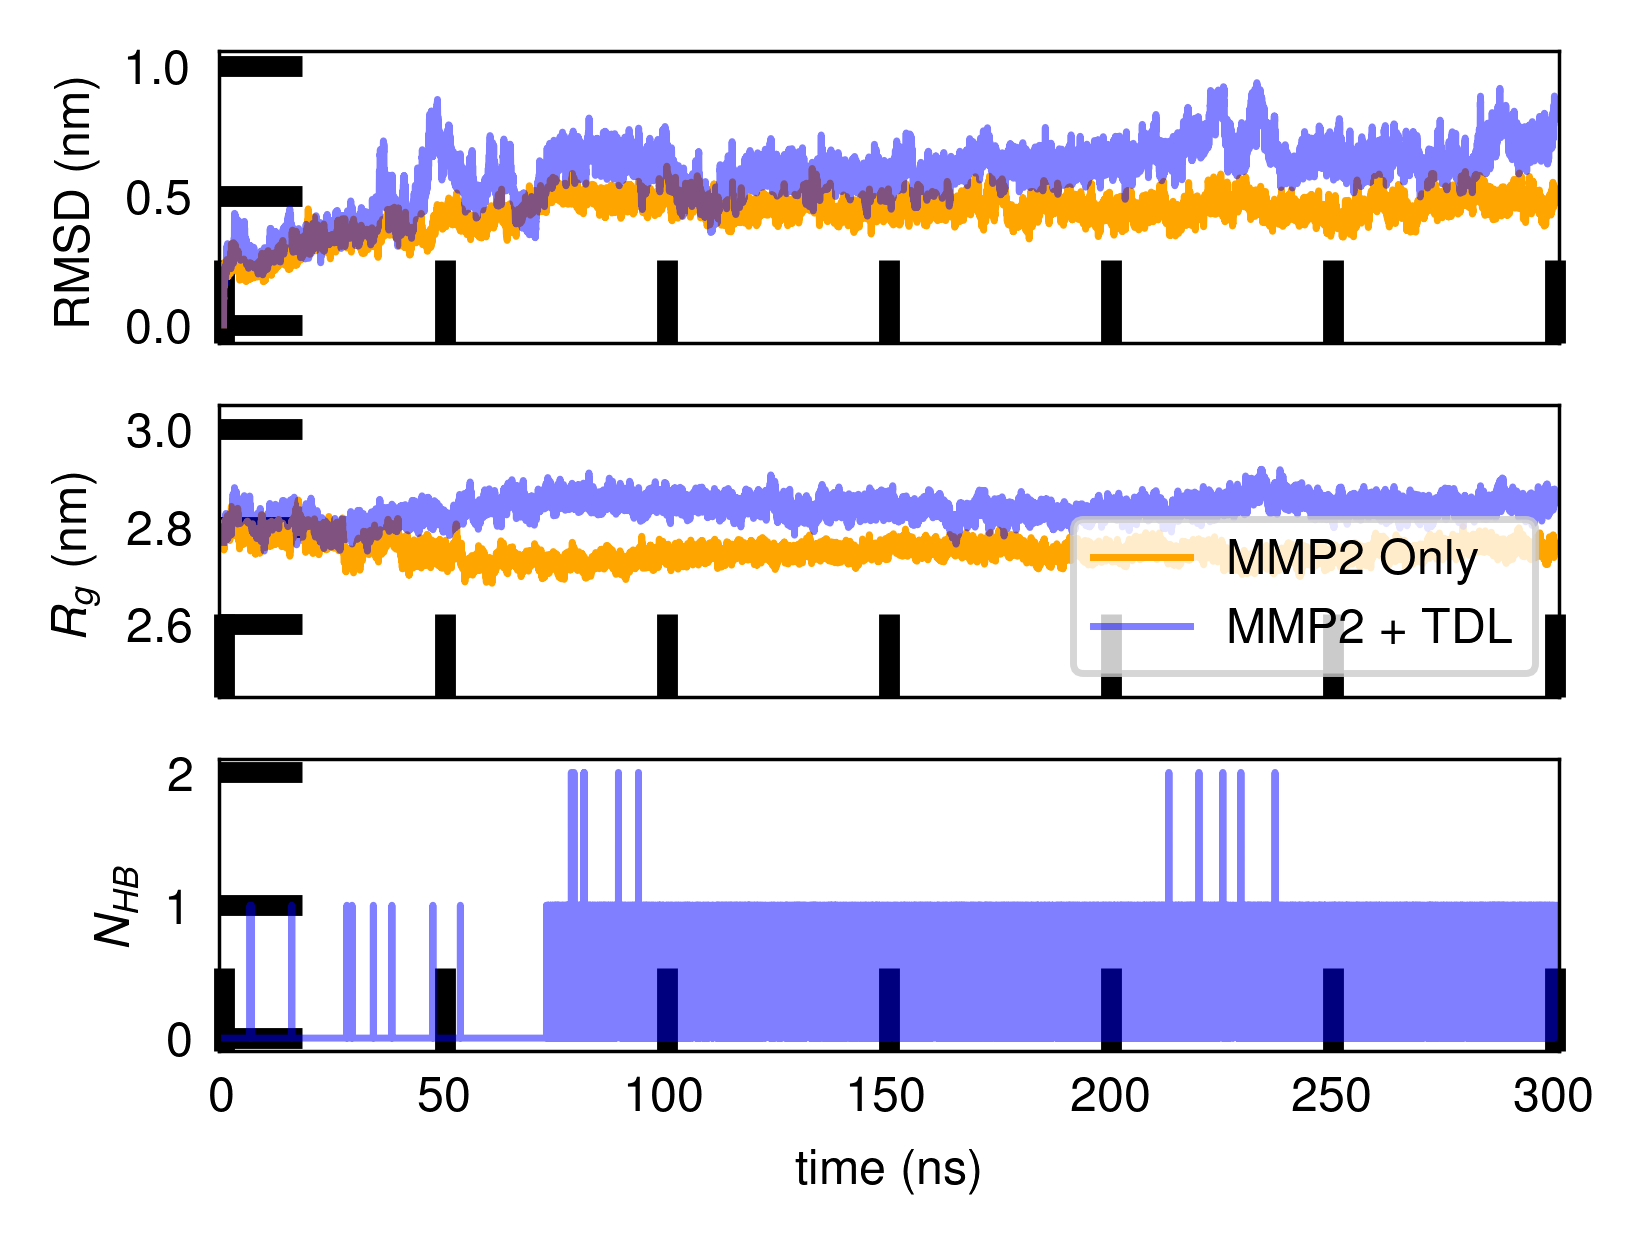

In [49]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="MMP2 Only", 
        color='orange')
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="MMP2 + TDL", 
        alpha=0.5, color='blue')
ax_rmsd.set_ylim(-0.07, 1.06)

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, 
        label="MMP2 Only", color='orange')
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="MMP2 + TDL", alpha=0.5,color='blue')
ax_rg.set_ylabel(r'$R_g$ (nm)');
ax_rg.set_ylim(2.45, 3.05)
ax_rg.legend()

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 301);

ax_bonds.plot(hbonds_prot_tdl.times/1000, hbonds_prot_tdl.count_by_time(), 
        lw=1, label="MMP2 + TDL", alpha=0.5,color='blue')

#plt.title("Number of hydrogon bonds over time", weight="bold")
ax_bonds.set_ylabel(r"$N_{HB}$")
plt.savefig("time-series-plots.png", dpi=600)
plt.show()


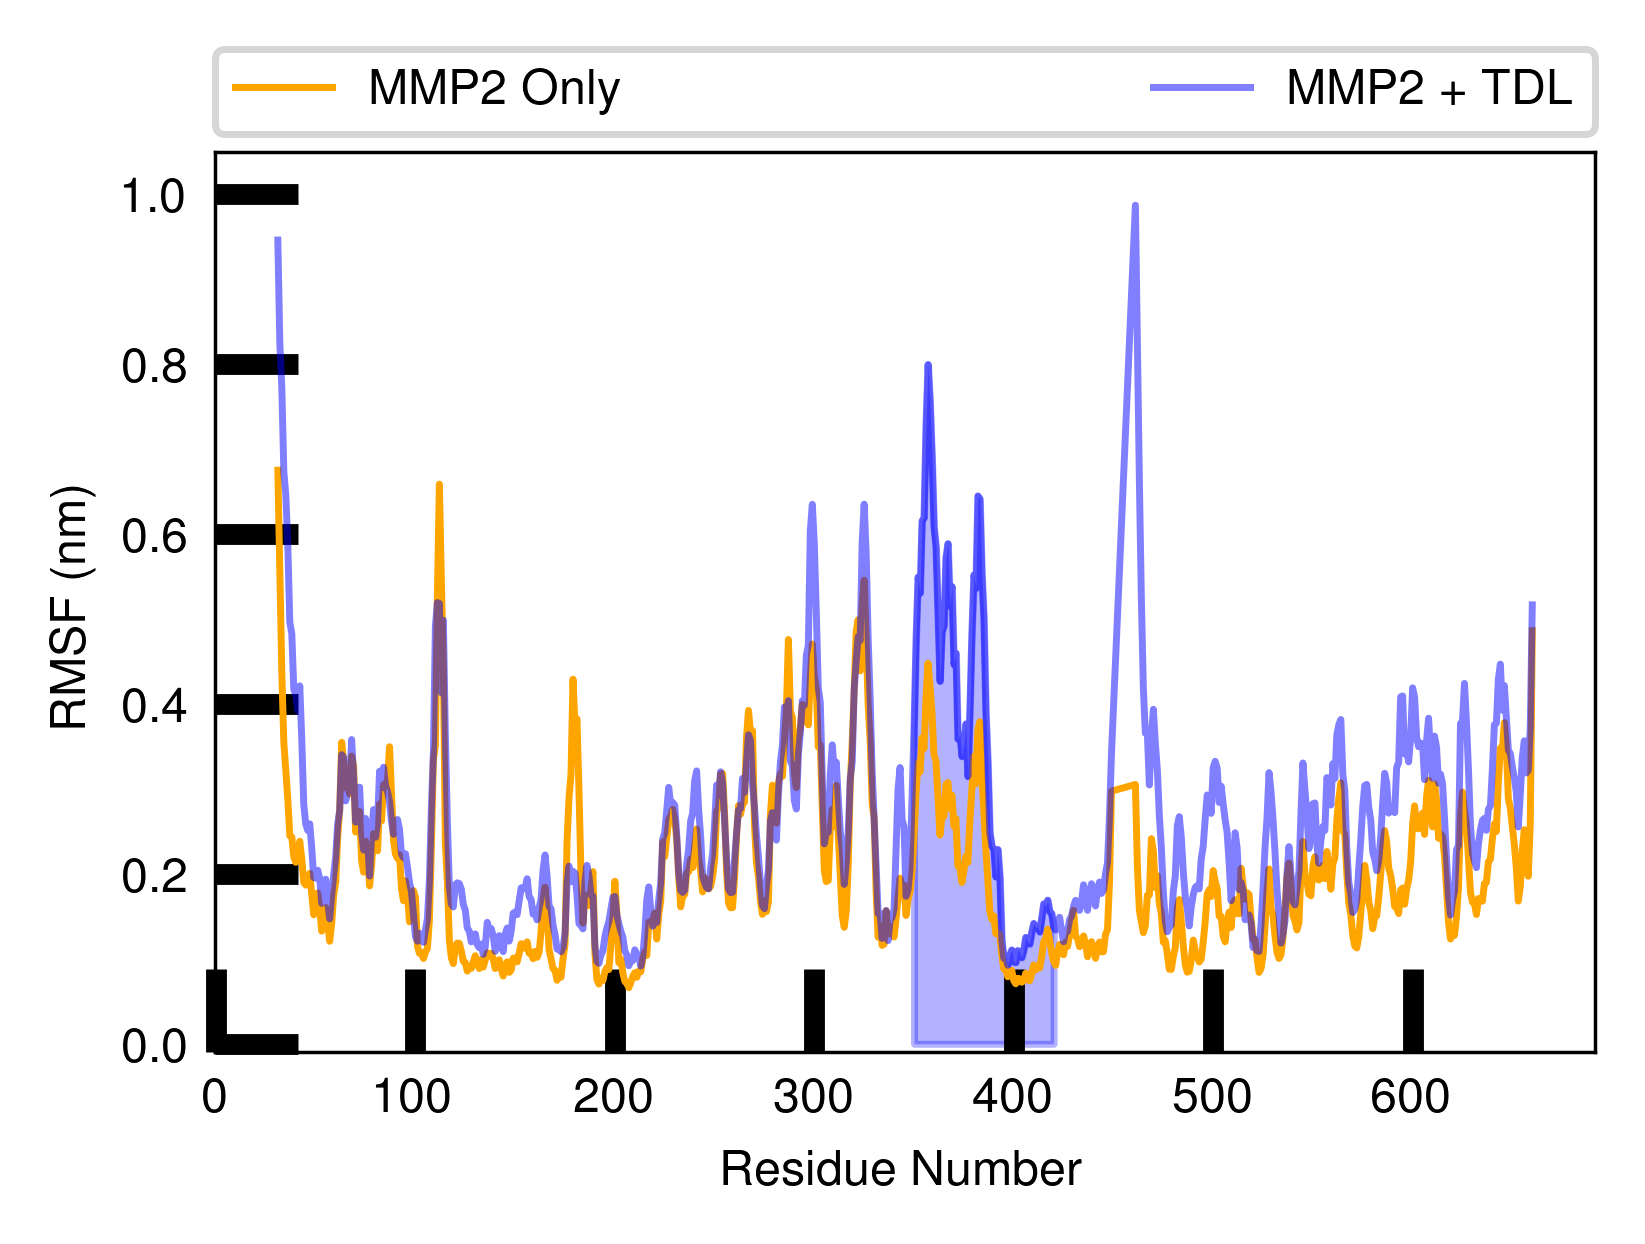

In [62]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('nature')
#npanels = 3

line_p, = plt.plot(c_alphas_p.resids, R_p.results.rmsf/10, label="MMP2 Only", 
                color="orange")
line_c, = plt.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="MMP2 + TDL", 
                alpha=0.5, color="blue")
plt.fill_between(c_alphas_c.resids, R_c.results.rmsf/10,\
    where=(c_alphas_c.resids >= 350) & (c_alphas_c.resids <= 420), color="blue", alpha=0.3)
plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.)

plt.ylim(-0.01, 1.05)
plt.savefig("rmsf.png", dpi=600)


## Hydrogen Bond lifetimes via correlation analysis: 

For each of the bond pairs selected from the gaggle above, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.

**Note:** In this simulation, all the hydrogen bonds seem to be intermittent, as the bond probabilities are very low.

### List most frequent bonds

Let’s first find all hydrogen bonds frames for the residues determined by the analysis above.

In [2]:
#Giving full tpr file to include bonding info
u = mda.Universe("mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex.tpr",\
            "mmp2_tdl_complex_sim/sys_prod/prod_mmp2_tdl_complex_compact_compact.xtc")
tdl = u.select_atoms('resname TDL')
protein = u.select_atoms('protein')
num_residues = len(protein.residues)

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [4]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_prot_tdl = HBA(universe=u,
        d_h_cutoff=1.2,
        d_a_cutoff=3.35,
        d_h_a_angle_cutoff=150.0,
        update_selections=False
        )

hbonds_prot_tdl.donors_sel = hbonds_prot_tdl.guess_donors("protein")
hbonds_prot_tdl.hydrogens_sel = hbonds_prot_tdl.guess_hydrogens("protein")
hbonds_prot_tdl.acceptors_sel = hbonds_prot_tdl.guess_acceptors("resname TDL")

hbonds_prot_tdl.run(verbose=True)

  0%|          | 0/30001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.35 between Donor, (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ASH and name OD2) or (resname ASN and name ND2) or (resname GLH and name OE2) or (resname GLN and name NE2) or (resname SER and name OG) or (resname THR and name OG1) or (resname TYR and name OH), and Acceptor, (resname TDL and name O1) or (resname TDL and name O2).
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150.0 between Donor, (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ASH and name OD2) or (resname ASN and name ND2) or (resname GLH and name OE2) or (resname GLN an

Now, sort and arrange the bonds according to donor residue ids.

In [10]:
import pandas as pd
hbonds_each = []
counts = hbonds_prot_tdl.count_by_ids()
for each in counts:
    hbonds_each.append(each)
lines = []
for donor, hydrogen, acceptor, count in counts:
    d, h, a = u.atoms[donor], u.atoms[hydrogen], u.atoms[acceptor]
    lines.append(f"{d.name} ({d.resid}{d.resname})--{h.name}::{a.name}({a.resname}) count={count}")

df = pd.DataFrame(sorted(lines), columns=['Hydrogen Bond'])
print(df)


                            Hydrogen Bond
0        NE (145ARG)--HE::O1(TDL) count=1
1     NE2 (119GLN)--HE22::O2(TDL) count=1
2     NH2 (145ARG)--HH22::O1(TDL) count=1
3     OG1 (396THR)--HG1::O2(TDL) count=21
4  OG1 (398THR)--HG1::O1(TDL) count=17277


Hydrogen bond analysis repeated with more refined selections, choosing the top residue from above.

In [16]:
resnums = 398
rn = resnums
hbonds_top =  HBA(universe=u,
        d_h_cutoff=1.2,
        d_a_cutoff=3.35,
        d_h_a_angle_cutoff=150.0,
        update_selections=False
        )
hbonds_top.acceptors_sel = hbonds_top.guess_acceptors("resname TDL")
hbonds_top.donors_sel = "resnum "+str(rn)+" and ("
hbonds_top.donors_sel += hbonds_top.guess_donors("resnum "+str(rn)) + ")"
hbonds_top.hydrogens_sel = hbonds_top.guess_hydrogens("resnum "+str(rn))
print("Donors: ", hbonds_top.donors_sel)
print("Hydrogens: ", hbonds_top.hydrogens_sel)
print("Acceptors: ", hbonds_top.acceptors_sel)
hbonds_top.run(verbose=True)

Donors:  resnum 398 and ((resname THR and name OG1))
Hydrogens:  (resname THR and name HG1)
Acceptors:  (resname TDL and name O1) or (resname TDL and name O2)


  0%|          | 0/30001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.35 between Donor, resnum 398 and ((resname THR and name OG1)), and Acceptor, (resname TDL and name O1) or (resname TDL and name O2).
  warnings.warn(
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 150.0 between Donor, resnum 398 and ((resname THR and name OG1)), and Acceptor, (resname TDL and name O1) or (resname TDL and name O2).
  warnings.warn(


In [22]:
hbonds_top.results.hbonds

array([[7.27900000e+03, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.66334997e+00, 1.61197672e+02],
       [7.28000000e+03, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.66272635e+00, 1.77797792e+02],
       [7.28200000e+03, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.94583180e+00, 1.58891231e+02],
       ...,
       [2.99980000e+04, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.57818672e+00, 1.78307796e+02],
       [2.99990000e+04, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.52651739e+00, 1.68148721e+02],
       [3.00000000e+04, 6.03200000e+03, 6.03300000e+03, 9.59200000e+03,
        2.71028856e+00, 1.71826792e+02]])

Now we’ll calculate the lifetime of this hydrogen bond. To do this, the simplest way is to run `HydrogenBondAnalysis` for each hydrogen bond then use the `lifetime` method. It is very efficient to find hydrogen bonds between two specific atoms, especially with `update_selections=False`.

This takes too long for continuous bonds, where tau_max should be large. Use the autocorrelation and solve routines instad.

In [ ]:
tau_max = 1000 # 1 ns?
tau, hbl = hbonds_top.lifetime(tau_max=tau_max)

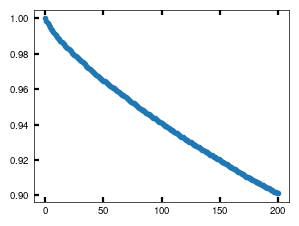

In [24]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('nature')
plt.plot(tau, hbl, marker='o')

### TODO
Finally, we can estimate the lifetime by fitting to exponential function (see references below)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} + \left(1-A_1 - A_2\right) e^{-t/\tau_3}
\end{equation*}

Here, the last term is said to contribute to the intermittent nature of the hydrogen bonds. The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

In [ ]:
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2, A3, tau3):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2) + A3 * np.exp(-x/tau3)

intermittency_time = intermittency * u.trajectory.dt/1000
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(3*my_width, 3*my_width/golden)
ax.set_title(f"Hydrogen Bond lifetimes: Intermittency = {intermittency_time} ns")


# Plot the lifetimes
symbols = ['o', 's', 'D', '^', 'x', '*', 'v', 'p', 'h']  # List of symbols to cycle through

# Plot the lifetimes
for i, hbl in enumerate(hbond_lifetimes):
    taus, hbl = hbl[:, 0], hbl[:, 1]
    times = taus * u.trajectory.dt/1000
    
    try:
        popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[0.5, 10, 0.5, 20, 0.1, 30], maxfev=5000)
        fit_times = np.linspace(times[0], times[-1], 100)
        fit_hbl = hbond_corr(fit_times, *popt)
        tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
        tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 
        stride = 4 if i == 4 else 3
        if tau_i_ps > 1:
            ax.plot(fit_times, fit_hbl, color='black', ls='--', lw=2, alpha=0.3)
            ax.scatter(times[::stride], hbl[::stride], label=labels[i] + fr' $\tau_i = {tau_i_ps}\; ps$', lw=2, s=20,marker=symbols[i])
    except RuntimeError as e:
        print(f"Could not fit {labels[i]}")
        print(f"Exception: {e}")
        ax.scatter(times[::stride], hbl[::stride], label=labels[i], lw=2, s=20,marker=symbols[i])
        continue
    

ax.set_xlabel(r"$t \rm (ns)$")
ax.set_ylabel(r"$C_I(t)$ (log-scale)")

ax.set_yscale("log")
ax.set_ylim(1.2e-2, 1.1)
ax.yaxis.set_tick_params(which='minor', length=8, width=1.5)
ax.legend(ncol=2, loc="upper right")
plt.savefig("hbond_lifetimes.png", dpi=600)
plt.show()

### References
1. Gowers RJ, Carbone P. A multiscale approach to model hydrogen bonding: The case of polyamide. The Journal of Chemical Physics. 2015;142(22):224907. [doi:10.1063/1.4922445](http://dx.doi.org/10.1063/1.4922445).
2. [MDAnalysis Guide (deprecated)](https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/hbond_autocorrel.html)

Is it really worthwhile to plot distances and angles with time if the bond probabilities are so low?

### Pretty Pics

Dump out PDBs and view pymol, since nglview seems to be crap. See below.

Also, do 2D representations in [LigPlot+](https://www.ebi.ac.uk/thornton-srv/software/LigPlus/).

Detect hydrogen bonds and write them into the PDB file as per instructions in LigPlot+ manual.

Select the most common residue ids that acted as acceptors.

Take the top-5 hbonds detected from the bar charts above, and enter each bond information into a list of dictionaries with first key being frameid and second being the bond string as specified by the ligplot+ manual. See 'Adding missing H-bonds' in [ligplot+ manual](https://www.ebi.ac.uk/thornton-srv/software/LigPlus/manual2/manual.html)

In [36]:
hbonds_top5_list = []
donor_chain = 'X'
acceptor_chain = 'A'
for hbonds in hbonds_top5:
    hbond = hbonds.results.hbonds[0]
    frame_idx, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle = hbond
    frame_idx, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle = \
        int(frame_idx), int(donor_index), int(hydrogen_index), int(acceptor_index), DA_distance, DHA_angle
    donor = u.atoms[donor_index]
    hydrogen = u.atoms[hydrogen_index]
    acceptor = u.atoms[acceptor_index]
    space = ' '
    donor_string = f'{donor.resname}' + space + donor_chain + space + str(donor.resid).rjust(4) + 3*space + donor.name.ljust(3)
    acceptor_string = f'{acceptor.resname}' + space + acceptor_chain + space + str(acceptor.resid).rjust(4) + 3*space + acceptor.name.ljust(3)

    bond_entry = 'HHB' + 3*space + donor_string + 5 * space + acceptor_string +    4 * space + f'{DA_distance:.2f}'
    hbonds_top5_list.append([frame_idx, bond_entry])
    
hbonds_top5_list

[[13, 'HHB   PHZ X  144   N2      HID A   60   NE2    2.90'],
 [3520, 'HHB   PHZ X  144   N2      LEU A   88   O      2.97'],
 [3255, 'HHB   PHZ X  144   N2      HID A   89   NE2    2.93'],
 [2985, 'HHB   PHZ X  144   N2      LEU A   93   O      2.84'],
 [6179, 'HHB   PHZ X  144   N2      ASN A   99   OD1    2.98']]

### Write each frame data to PDB and draw the hbonds in
Each PDB can be seen in 3D using `pymol` or 2D using `ligplot+`. The hbonds are written into the PDBs in case ligplot+ misses them. 

In [38]:
import os
from tqdm import tqdm

complex_prod = u.select_atoms('protein or resname PHZ')
out_dir = 'zeb_hb_phz_complex_sim/sys_prod/pdb_files'
os.makedirs(out_dir, exist_ok=True)

for hbond in tqdm(hbonds_top5_list):
    frame_idx, bond_entry = hbond

    for ts in u.trajectory:
        if ts.frame == frame_idx:
            pdb_filename = f'complex_time_{int(ts.time)}_ps.pdb'
            pdb_filename = os.path.join(out_dir, pdb_filename)
            complex_prod.write(pdb_filename)
            with open(pdb_filename, 'r') as file:
                lines = file.readlines()

            lines.insert(2, bond_entry + '\n')

            with open(pdb_filename, 'w') as file:
                file.writelines(lines)
            break

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found

Finally, save the first frame (initial condition) into a PDB as well.

In [3]:
import os
from tqdm import tqdm

complex_prod = u.select_atoms('protein or resname PHZ')
out_dir = 'zeb_hb_phz_complex_sim/sys_prod/pdb_files'
os.makedirs(out_dir, exist_ok=True)

for ts in u.trajectory:
    if ts.frame == 0:
        pdb_filename = f'complex_init.pdb'
        pdb_filename = os.path.join(out_dir, pdb_filename)
        complex_prod.write(pdb_filename)
        break

/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/miniforge3/envs/mdanalysis-develop/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1155: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/usr/